<a href="https://colab.research.google.com/github/SreeDev-4522/KMC_COV_ResUnet-/blob/main/ResUnet_KMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# src = list(files.upload().values())[0]
# open('ss_utils.py','wb').write(src)
# import ss_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install tensorflow_addons
!pip install --upgrade jax jaxlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


data.py

In [ ]:
import os,cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import glob

class1 = [0,160,255] #blue
class2 = [255,255,128] #yellow
class3 = [255,0,0] #red
class0 = [0,0,0] #background which is the final class

check_path = os.path.dirname(os.getcwd()) + "/Results/check"
label_values = [class1] + [class2] + [class3] + [class0]
num_classes = len(label_values)

def one_hot(mask):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = (np.stack(semantic_map, axis=-1)).astype(float)
    return semantic_map

def adjustData(img,mask):
    img = img / 255
    mask = one_hot(mask)
    return (img,mask)

def dataGenerator(batch_size,path,aug_dict,size,seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
       save_to_dir = "/content/drive/MyDrive/KMC/Check/Image",
       save_prefix = 'image',
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
       save_to_dir = "/content/drive/MyDrive/KMC/Check/Mask",
       save_prefix= 'mask',
        seed = seed)
    data_generator = zip(image_generator, mask_generator)
    for (image,mask) in data_generator:
        image,mask = adjustData(image,mask)
        yield (image,mask)
        
def valGenerator(batch_size,path,size,seed=1):
    image_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    data_generator = zip(image_generator, mask_generator)
    for (image,mask) in data_generator:
        image,mask = adjustData(image,mask)
        yield (image,mask)        

def dataGenerator2(batch_size,path,aug_dict,seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["ul_val_images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask2_generator = image_datagen.flow_from_directory(
        path,
        target_size=(size, size),
        classes = ["ul_val_mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    data_generator = zip(image_generator, mask_generator,image2_generator, mask2_generator)
    for (image,mask,image2,mask2) in data_generator:
        image,mask = adjustData(image,mask)
        image2,mask2 = adjustData(image2,mask2)
        yield [[image,image2],[mask,mask2]]

def dataGenerator3(batch_size,path1,path2,aug_dict,size,size2,k=2,T=0.5,seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path2,
        target_size=(size2, size2),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    data_generator = zip(image_generator, mask_generator,image2_generator)
    for (image,mask,image2) in data_generator:
        image,mask = adjustData(image,mask)
        image2/=255
        mask2 = np.repeat(mask,k,axis=0)
        train = ([image,image2],[mask,mask2])
        yield train
        

def dataGenerator4(batch_size,path1,path2,aug_dict,size,size2,k=2,T=0.5,seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path2,
        target_size=(size2, size2),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    data_generator = zip(image_generator, mask_generator,image2_generator)
    for (image,mask,image2) in data_generator:
        image,mask = adjustData(image,mask)
        image2/=255
        mask2 = np.repeat(mask,k,axis=0)
        mask = np.concatenate((mask,mask2),axis=0)
        m,n,o,p=mask.shape
        mask = np.reshape(mask,(m,n*o,p))
        mask = mask[np.newaxis,:]
        train = ([image,image2],mask)
        yield train
def dataGenerator5(batch_size,path1,path2,aug_dict,size,size2,k=2,T=0.5,seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size2, size2),
        classes = ["images_padded"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path2,
        target_size=(size2, size2),
        classes = ["images_padded"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    data_generator = zip(image_generator, mask_generator,image2_generator)
    for (image,mask,image2) in data_generator:
        image,mask = adjustData(image,mask)
        image2/=255
        mask2 = np.repeat(mask,k,axis=0)
        mask = np.concatenate((mask,mask2),axis=0)
        m,n,o,p=mask.shape
        mask = np.reshape(mask,(m,n*o,p))
        mask = mask[np.newaxis,:]
        train = ([image,image2],mask)
        yield train 
   
                    
def valGenerator3(batch_size,path1,path2,size,size2,k=2,T=0.5,seed=1):
    image_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path2,
        target_size=(size2, size2),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask2_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size2, size2),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)        
    data_generator = zip(image_generator, mask_generator,image2_generator, mask2_generator)
    for (image,mask,image2,mask2) in data_generator:
        image,mask = adjustData(image,mask)
        image2,mask2 = adjustData(image2,mask2)
        mask2 = np.repeat(mask2,k,axis=0)
        train = ([image,image2],{'augm_layer_1':mask,'augm_layer_3':mask2})
        yield train
        
def valGenerator4(batch_size,path1,path2,size,size2,k=2,T=0.5,seed=1):
    image_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path2,
        target_size=(size2, size2),
        classes = ["images"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask2_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)        
    data_generator = zip(image_generator, mask_generator,image2_generator, mask2_generator)
    for (image,mask,image2,mask2) in data_generator:
        image,mask = adjustData(image,mask)
        image2,mask2 = adjustData(image2,mask2)
        mask2 = np.repeat(mask2,k,axis=0)
        mask = np.concatenate((mask,mask2),axis=0)
        m,n,o,p=mask.shape
        mask = np.reshape(mask,(m,n*o,p))
        mask = mask[np.newaxis,:]
        train = ([image,image2],mask)
        yield train

def valGenerator5(batch_size,path1,path2,size,size2,k=2,T=0.5,seed=1):
    image_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size2, size2),
        classes = ["images_padded"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    image2_generator = image_datagen.flow_from_directory(
        path2,
        target_size=(size2, size2),
        classes = ["images_padded"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    mask2_generator = image_datagen.flow_from_directory(
        path1,
        target_size=(size, size),
        classes = ["mask"],
        class_mode = None,
        batch_size = batch_size,
        seed = seed)        
    data_generator = zip(image_generator, mask_generator,image2_generator, mask2_generator)
    for (image,mask,image2,mask2) in data_generator:
        image,mask = adjustData(image,mask)
        image2,mask2 = adjustData(image2,mask2)
        mask2 = np.repeat(mask2,k,axis=0)
        mask = np.concatenate((mask,mask2),axis=0)
        m,n,o,p=mask.shape
        mask = np.reshape(mask,(m,n*o,p))
        mask = mask[np.newaxis,:]
        train = ([image,image2],mask)
        yield train
        

        
def sharpen1(p, T):
    return np.power(p, 1/T) / np.mean(np.power(p, 1/T), axis=-1, keepdims=True)
    
def sharpen(p, T):
    return tf.pow(p, 1/T) / tf.reduce_sum(tf.pow(p, 1/T), axis=1, keepdims=True)


def num_of_images(path):
    image_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        path,
        classes = ["mask"],
        class_mode = None)
    return image_generator.samples

def num_of_images2(path):
    image_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        path,
        classes = ["ul__val_images"],
        class_mode = None)
    return image_generator.samples

#mask name should end with '_gt' following the image name
def validation(image_path,mask_path,image_prefix = ".png",mask_prefix = "_gt.png"):
    image_name_arr = glob.glob(os.path.join(image_path,"*%s"%image_prefix))

    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):

        img = cv2.cvtColor(cv2.imread(item),cv2.COLOR_BGR2RGB)
        mask= cv2.cvtColor(cv2.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix)),cv2.COLOR_BGR2RGB)
        img = img[:,:,:3]
        mask = mask[:,:,:3] if mask.ndim==3 else np.repeat(mask[:,:,np.newaxis],3,axis=-1)
        img,mask = adjustData(img,mask)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr, image_name_arr

def validation2(image_path):
    image_name_arr = glob.glob(os.path.join(image_path,"*.png"))
    image_arr = []
    for index,item in enumerate(image_name_arr):
        img = cv2.cvtColor(cv2.imread(item),cv2.COLOR_BGR2RGB)
        img = img[:,:,:3]
        img = img/255
        image_arr.append(img)
    image_arr = np.array(image_arr)
    return image_arr, image_name_arr
    
def weight(mask_path,mask_prefix = "_gt.png"):
    image_name_arr = glob.glob(os.path.join(mask_path,"*%s"%mask_prefix))
    no_images = len(image_name_arr)
    class_1=0
    class_2=0
    class_3=0
    class_0=0
    tot = size*size*no_images
    for index,item in enumerate(image_name_arr):
        mask = cv2.cvtColor(cv2.imread(item),cv2.COLOR_BGR2RGB)
        mask = mask[:,:,:3] 
        class_1 += np.sum(np.all(mask==class1,axis=-1))
        class_2 += np.sum(np.all(mask==class2,axis=-1))
        class_3 += np.sum(np.all(mask==class3,axis=-1))
        class_0 += np.sum(np.all(mask==class0,axis=-1))
    class1_wt = (tot - class_1)/tot
    class2_wt = (tot - class_2)/tot
    class3_wt = (tot - class_3)/tot
    class0_wt = (tot - class_0)/tot
    class_weight = [class1_wt,class2_wt,class3_wt,class0_wt]
    return class_weight,no_images


ss_utils.py

In [ ]:
import tensorflow_addons as tfa
import tensorflow as tf
from keras.layers import Layer
import keras.backend as K
import numpy as np
from pathlib import Path
from sklearn.utils import shuffle
import cv2

def parameter_sampling(augm_per_image=10):
    HORIZONTAL_FLIP_PROBALITIY=0.5
    VERTICAL_FLIP_PROBALITIY=0.5
    SHIFT_PROBALITIY=0.5
    ROTATE_PROPBABILITY=0.5
    ZOOM_PROPBABILITY=0.2
    MAXIMUM_ROTATION_ANGLE=5
    MAXIMUM_SHIFT=5
    MINIMUM_ZOOM=0.8
    MAXIMUM_ZOOM=1.2
    
    coin1 = np.less(np.random.uniform(0, 1.0,augm_per_image), ROTATE_PROPBABILITY) # for enabling rotation
    coin2 = np.less(np.random.uniform(0, 1.0,2*augm_per_image), SHIFT_PROBALITIY) # for enabling shifting
    coin2 = np.reshape(coin2,(augm_per_image,2)) # reshaping to 2 columns for height and width shift  
    coin3 = np.less(np.random.uniform(0,1.0,(augm_per_image,)), ZOOM_PROPBABILITY)  # for enabling zoom  
    h_flips = np.less(np.random.uniform(0, 1.0,augm_per_image), HORIZONTAL_FLIP_PROBALITIY) # An array of bolean values which tells horizontally flip or not.    
    v_flips = np.less(np.random.uniform(0, 1.0,augm_per_image), VERTICAL_FLIP_PROBALITIY) # An array of bolean values which tells vertically flip or not.
    shift = np.random.randint( 0, MAXIMUM_SHIFT, 2*augm_per_image) # An array of a pair of values for height and width shift
    shift = np.reshape(shift,(augm_per_image,2)) # reshaping to 2 columns for height and width shift
    shift *= coin2 # multiplying parameter with coin to enabling augmentation only when coin is True
        
    inv_shift = shift*-1    # inverse parameter for shifting
    angle_rad = MAXIMUM_ROTATION_ANGLE * 3.141592653589793 / 180.0
    angles = np.random.uniform(-angle_rad, angle_rad, augm_per_image) # angles in radian
    inv_angle = angles*-1 # inverse parameter for rotation
    scales = np.random.uniform(MINIMUM_ZOOM,MAXIMUM_ZOOM,(augm_per_image,)) # zoom in and out range
    scales *= coin3 # multiplying parameter with coin to enabling augmentation only when coin is True
    scales[(scales==0.0)] = 1.0 # No zoom is when scale is 1. so 0 is changed to 1.
    
    boxes = np.zeros((len(scales), 4)) # boxes for zoom is created with 4 parameters(x1,y1,x2,y2) the minimum and maximum cordinates
    inv_boxes = np.zeros((len(scales), 4)) # inverse parameter for zoom
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale) 
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
        x3 = y3 = 0.5 - (0.5 / scale)
        x4 = y4 = 0.5 + (0.5 / scale)
        inv_boxes[i] = [x3, y3, x4, y4]
    box_indices = np.arange(0,len(scales))
    return h_flips,v_flips,angles,inv_angle,shift,inv_shift,boxes,box_indices,inv_boxes  #parameters for augmentation and reverse augmentation

def proj_translations(translations):
    num_translations = tf.shape(translations)[0]
        # The translation matrix looks like:
        #     [[1 0 -dx]
        #      [0 1 -dy]
        #      [0 0 1]]
        # where the last entry is implicit.
        # Translation matrices are always float32.
    return tf.concat(
            values=[
                tf.ones((num_translations, 1), tf.float32),
                tf.zeros((num_translations, 1), tf.float32),
                -translations[:, 0, None],
                tf.zeros((num_translations, 1), tf.float32),
                tf.ones((num_translations, 1), tf.float32),
                -translations[:, 1, None],
                tf.zeros((num_translations, 2), tf.float32),
            ],
            axis=1,
        )
# classes for each type of augmentation

class HorizontalFlip():     
    def __init__(self, h_flips,**kwargs):
        self.h_flips = h_flips
       
    def __call__(self, img, **kwargs):
        batch_size = tf.shape(img)[0]
        flip_size = tf.shape(self.h_flips)[0]  #gives the no. of augmentaion
        flips = tf.reshape(self.h_flips, [flip_size, 1, 1, 1]) # making flips as the same dimension of image for broadcasting
        flips = tf.cast(flips, img.dtype)
        flipped_input = tf.reverse(img, [2]) # reversing the columns of the image
        im = flips * flipped_input + (1 - flips) * img # To flip the image only when the parameter flips is True
        return im

class VerticalFlip():
    def __init__(self, v_flips,**kwargs):
        self.v_flips = v_flips
        
    def __call__(self, img, **kwargs):
        batch_size = tf.shape(img)[0]
        flip_size = tf.shape(self.v_flips)[0] #gives the no. of augmentaion
        flips = tf.reshape(self.v_flips, [flip_size, 1, 1, 1])  # making flips as the same dimension of image for broadcasting
        flips = tf.cast(flips, img.dtype)   
        flipped_input = tf.reverse(img, [1]) # reversing the rows of the image
        im = flips * flipped_input + (1 - flips) * img #To flip the image only when the parameter flips is True
        return im

class RandomRotate():
    def __init__(self, angles,**kwargs):
        self.angles = angles
        
    def __call__(self, img, **kwargs):
        shp = tf.shape(img)
        batch_size, height, width = shp[0], shp[1], shp[2]
        f = tfa.image.transform_ops.angles_to_projective_transforms(self.angles, tf.cast(height, tf.float32), tf.cast(width, tf.float32))
        img = tf.raw_ops.ImageProjectiveTransformV2(images=img, transforms=f, output_shape=[height,width], interpolation='NEAREST', fill_mode='REFLECT', name=None)
        return img

class Height_Width_Shift():
    __name__ = "Height_Width_Shift" 
    def __init__(self, shift,**kwargs):
        self.shift = shift
        
    def __call__(self, img, **kwargs):
        shp = tf.shape(img)
        batch_size, height, width = shp[0], shp[1], shp[2]
        f = tfa.image.translate_ops.translations_to_projective_transforms(self.shift)
        #f = proj_translations(self.shift)
        img = tf.raw_ops.ImageProjectiveTransformV2(images=img, transforms=f, output_shape=[height,width], interpolation='NEAREST', fill_mode='REFLECT', name=None)
        #img = tf.contrib.image.transform(images=img, transforms=f, interpolation='NEAREST')
        return img

class Crop_Resize():
    def __init__(self, boxes,box_indices,**kwargs):
        self.boxes = boxes
        self.box_indices = box_indices
        
    def __call__(self, img, **kwargs):
        shp = tf.shape(img)
        batch_size, height, width = shp[0], shp[1], shp[2]
        CROP_SIZE = (height, width)
        img = tf.image.crop_and_resize(img, self.boxes, self.box_indices, CROP_SIZE) #
        return img

# function which perform all the augmntations
def augment(inputs, transforms):
    for t in transforms:
        inputs = t(inputs)
    return inputs


def resize_if_needed(img, output_dim):
    shp = tf.shape(img)
    batch_size, height, width, channels = shp[0], shp[1], shp[2], shp[3]
    if height != output_dim[0] or width != output_dim[1]:
        size = tf.constant(output_dim[:2], dtype=tf.int32)
        img = tf.image.resize(img, size=size)
    return img


# custom layer class for doing augmentation

class AugmLayer(Layer):
    def __init__(self, transforms, output_dim=None, preproc_input=None, **kwargs):
        self.output_dim = output_dim
        self.transforms = transforms
        self.preproc_input = preproc_input
        super(AugmLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(AugmLayer, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        ret = K.in_train_phase(augment(inputs, self.transforms), inputs, training=training)
        if self.output_dim is not None:
            ret = resize_if_needed(ret, self.output_dim)
        if self.preproc_input is not None:
            ret = self.preproc_input(ret)
        return ret


def transforms(m):
    h_flips,v_flips,angles,inv_angle,shift,inv_shift,boxes,box_indices,inv_boxes = parameter_sampling(m) # created the parameters for augmentation of labelled images

    transforms = [
    HorizontalFlip(h_flips),
    VerticalFlip(v_flips),
    Height_Width_Shift(shift),
    #RandomRotate(angles),
    Crop_Resize(boxes,box_indices)
    ] 

    inv_transforms = [              
    Crop_Resize(inv_boxes,box_indices),
    #RandomRotate(inv_angle),
    Height_Width_Shift(inv_shift),
    VerticalFlip(v_flips),
    HorizontalFlip(h_flips)
    ] 
    return transforms,inv_transforms  

# Meric for finding fscore 
def fscore(y_true,y_pred):
    y_true = y_true[:,:,:,:-1]
    y_pred = y_pred[:,:,:,:-1]
    y_true = K.round(K.flatten(y_true))
    y_pred = K.round(K.flatten(y_pred)) 
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    possible_positives = K.sum(K.round(y_true))
    precision = true_positives / (predicted_positives+ K.epsilon())   
    recall = true_positives / (possible_positives+ K.epsilon())  
    f_score1 = 2*((precision*recall)/(precision+recall+ K.epsilon()))
    return f_score1    
  
 
def fscore_benign(y_true,y_pred):
    y_true1 = y_true[...,0]
    y_pred1 = y_pred[...,0]
    y_true1 = K.round(K.flatten(y_true1))
    y_pred1 = K.round(K.flatten(y_pred1)) 
    true_positives1 = K.sum(y_true1 * y_pred1)
    predicted_positives1 = K.sum(y_pred1)
    possible_positives1 = K.sum(y_true1)
    precision1 = true_positives1 / (predicted_positives1+ K.epsilon())   
    recall1 = true_positives1 / (possible_positives1+ K.epsilon())  
    f_score1 = 2*precision1*recall1/(precision1+recall1+ K.epsilon())
    return f_score1  

def fscore_mal(y_true,y_pred):
    y_true2 = y_true[...,1]
    y_pred2 = y_pred[...,1]
    y_true2 = K.round(K.flatten(y_true2))
    y_pred2 = K.round(K.flatten(y_pred2)) 
    true_positives2 = K.sum(y_true2 * y_pred2)
    predicted_positives2 = K.sum(y_pred2)
    possible_positives2 = K.sum(y_true2)
    precision2 = true_positives2 / (predicted_positives2+ K.epsilon())   
    recall2 = true_positives2 / (possible_positives2+ K.epsilon())  
    f_score2 = 2*precision2*recall2/(precision2+recall2+ K.epsilon())
    return f_score2  
    
# Custom loss function

    
def semi_loss(y_actual,y_predicted):
    y_actual = y_actual[0]
    y_actual = tf.reshape(y_actual,[k+l,size,size,num_classes])
    cce = custom_ce(y_actual[0],y_predicted[0])
    mse = custom_mse(y_actual[1:],y_predicted[1:])    
    #cce = custom_ce(y_actual[0],y_predicted[0,64:-64,64:-64,:])
    #mse = custom_mse(y_actual[1:],y_predicted[1:,64:-64,64:-64,:])
    loss_value = cce + lambda_u * mse  
    return loss_value    

def custom_ce(y_actual,y_predicted):
    loss_value1 = -K.mean(K.sum( y_actual * K.log( y_predicted + K.epsilon()),axis=-1))
    return loss_value1 

def custom_ce1(y_actual,y_predicted):
    loss_value1 = -(K.sum(y_actual * K.log( y_predicted + K.epsilon()),axis=-1))
    return loss_value1 
             
def custom_mse(y_actual,y_predicted):
    loss_value2 = K.mean(K.mean( K.square(y_actual-y_predicted),axis=-1))
    return loss_value2

def colour_code(image, label_values):
    x = np.argmax(image, axis = -1)
    colour_codes = np.array(label_values)
    x = colour_codes[x.astype(int)]
    return x
    
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def shuffling2(x):
    x = shuffle(x)
    return x
    
def one_hot(mask):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = (np.stack(semantic_map, axis=-1)).astype(float)
    return semantic_map

def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = one_hot(mask)
    mask = mask.astype(np.float32)
    return mask


def loss_ul(y_actual,y_predicted):
    y_actual = tf.where(y_actual > 0.5, x = 1., y=0., name=None)
    y_actual = tf.cast(y_actual, dtype=tf.float32, name=None)
    cce = custom_ce1(y_actual,y_predicted)
    cce = cce[cce>0.]
    cce = tf.concat([cce,[0.0]],axis=-1)
    loss = K.mean(cce)
    return loss

cce_loss = tf.keras.losses.CategoricalCrossentropy()    


m_resunet.py

In [ ]:
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x


def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

class ResUnetPlusPlus:
    def __init__(self, input_size=512, no_classes=4):
        self.input_size = input_size
        self.classes = no_classes

    def build_model(self):
        n_filters = [16, 32, 64, 128, 256]
        inputs = Input((self.input_size, self.input_size, 3))

        c0 = inputs
        c1 = stem_block(c0, n_filters[0], strides=1)

        ## Encoder
        c2 = resnet_block(c1, n_filters[1], strides=2)
        c3 = resnet_block(c2, n_filters[2], strides=2)
        c4 = resnet_block(c3, n_filters[3], strides=2)

        ## Bridge
        b1 = aspp_block(c4, n_filters[4])

        ## Decoder
        d1 = attetion_block(c3, b1)
        d1 = UpSampling2D((2, 2))(d1)
        d1 = Concatenate()([d1, c3])
        d1 = resnet_block(d1, n_filters[3])

        d2 = attetion_block(c2, d1)
        d2 = UpSampling2D((2, 2))(d2)
        d2 = Concatenate()([d2, c2])
        d2 = resnet_block(d2, n_filters[2])

        d3 = attetion_block(c1, d2)
        d3 = UpSampling2D((2, 2))(d3)
        d3 = Concatenate()([d3, c1])
        d3 = resnet_block(d3, n_filters[1])

        ## output
        outputs = aspp_block(d3, n_filters[0])
        outputs = Conv2D(self.classes, (1, 1), padding="same")(outputs)
        outputs = Activation("softmax")(outputs)

        ## Model
        model = Model(inputs, outputs)
        return model

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import *
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras import layers
# from m_resunet import ResUnetPlusPlus
import tensorflow_addons as tfa
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Concatenate, Cropping2D
from keras.layers import Input,Layer,Lambda, AveragePooling2D, Activation, Concatenate, Cropping2D
import keras.backend as K
K.set_image_data_format('channels_last')
from keras import optimizers
import sys,math,csv,time
from pathlib import Path
from sklearn.utils import shuffle
import glob
# import ss_utils
# from ss_utils import *
#K.set_floatx('float64')


#cce = tf.keras.losses.categorical_crossentropy()
cce=tf.keras.losses.CategoricalCrossentropy()
loss_fn = cce
class1 = [0,160,255] #blue
class2 = [255,255,128] #yellow
class3 = [255,0,0] #red
class0 = [0,0,0] #background which is the final class

label_values = [class1] + [class2] + [class3] + [class0]
num_classes = len(label_values)

  
csv_name = "/content/drive/MyDrive/KMC/ResUnet++/CSV/training.csv"
csv_name2 = "/content/drive/MyDrive/KMC/ResUnet++/CSV/validation.csv"


train_path = "/content/drive/MyDrive/KMC/ResUnet++/Data_keras/10x/train_384/"
valid_path = "/content/drive/MyDrive/KMC/ResUnet++/Data_keras/10x/val_384/"

weights_folder= "/content/drive/MyDrive/KMC/ResUnet++/weight_sct/10x/weights_resunet11"

if os.path.isdir(weights_folder) is not True:
    os.mkdir(weights_folder)

model_name = "/content/drive/MyDrive/KMC/ResUnet++/modelh5/core_model.h5" 
## Training

train_xl = sorted(glob.glob(os.path.join(train_path, "images", "*.png")))   
train_yl = sorted(glob.glob(os.path.join(train_path, "mask", "*.png")))

## Shuffling
train_xl, train_yl = shuffling(train_xl, train_yl)


## Validation
valid_xl = sorted(glob.glob(os.path.join(valid_path, "images", "*.png")))
valid_yl = sorted(glob.glob(os.path.join(valid_path, "mask", "*.png")))

final_epoch = 12
lr = 1e-6
batch_size = 1 # No. of images in  training and validation batch
size =512
# weights_10x = [0.967,0.96,0.88,0.974,0.219]
rms = keras.optimizers.RMSprop(lr=1e-6)
opt = rms

checkpoint_path = model_name
# checkpoint_path = None
if checkpoint_path is not None:
   model = load_model(checkpoint_path, custom_objects={'fscore': fscore})
   model.load_weights("%s/weights.010.hdf5"%str(weights_folder)) # To continue from a particular epoch
   i_epoch = 11
else:
  arch = ResUnetPlusPlus(input_size=size,no_classes=4)
  model = arch.build_model()
  model._name="base_model"    
  i_epoch = 0


  
print(model.summary())
metrics = [
    fscore,
    fscore_benign,
    fscore_mal
   
    ]


num_train = len(train_xl)
num_valid = len(valid_xl)
train_steps = (num_train//batch_size)
valid_steps = (num_valid//batch_size)

# print(train_steps)
# print(valid_steps)



def data_aug(image,seed1):
    data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal",seed=seed1),
  # layers.RandomRotation(0.09, interpolation='nearest',seed=seed1),
  layers.RandomTranslation(height_factor=0.01, width_factor=0.01, fill_mode='reflect', interpolation='nearest', seed=seed1, fill_value=0.0),
  layers.RandomZoom(height_factor=(-0.1,0.1), width_factor=None, fill_mode='reflect',
    interpolation='nearest', seed=seed1, fill_value=0.0)])
    return data_augmentation(image)
    
    
def parse_data(x, y):
    def _parse(x, y):
        seed1 = tf.random.uniform(shape=[],minval=0,maxval=2048)
        x = read_image(x)
        y = read_mask(y)
        x = data_aug(x,seed1)
        y = data_aug(y,seed1)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([size, size, 3])
    y.set_shape([size, size, num_classes])
    return x, y


def tf_dataset(x, y, batch=1):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    #dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset
 


train_dataset = tf_dataset(train_xl, train_yl, batch=batch_size)  
valid_dataset = tf_dataset(valid_xl, valid_yl, batch=batch_size) 



callbacks = [
        ModelCheckpoint(filepath='%s/weights.{epoch:03d}.hdf5'%weights_folder,save_weights_only= True),
        CSVLogger(csv_name,append=True)
    ] 
    
start = time.time()
model.compile(optimizer = opt, loss = loss_fn, metrics =['accuracy',fscore], run_eagerly=True )
model.fit(train_dataset,
            epochs=final_epoch,
            validation_data=valid_dataset,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            callbacks=callbacks,
            shuffle=False,
            verbose=1,
            initial_epoch = i_epoch)
model.save(str(model_name))
end = time.time()
print(f"time taken for training {final_epoch - i_epoch} is {end - start} seconds")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "base_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                        

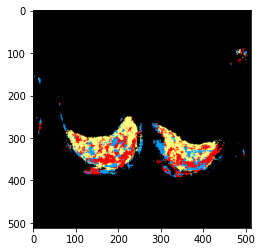

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import *
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *
from tensorflow.keras import layers
# from m_resunet import ResUnetPlusPlus
import tensorflow_addons as tfa
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Concatenate, Cropping2D
from keras.layers import Input,Layer,Lambda, AveragePooling2D, Activation, Concatenate, Cropping2D
import keras.backend as K
K.set_image_data_format('channels_last')
from keras import optimizers
import sys,math,csv,time
from pathlib import Path
from sklearn.utils import shuffle
import glob

model = load_model("/content/drive/MyDrive/KMC/ResUnet++/modelh5/core_model.h5", custom_objects={'fscore': fscore})
model.load_weights("%s/weights.012.hdf5" % str(weights_folder)) 

def colour_code(image, label_values):
    x = np.argmax(image, axis = -1)
    colour_codes = np.array(label_values)
    x = colour_codes[x.astype(int)]
    return x
what = model.predict(valid_dataset,steps=5)

z = colour_code(what,label_values)
# for i in range(len(z)):
#     a = img_name[i]
#     image_name = os.path.basename(a)
#     print(image_name)
#     out = z[i]
#     inp = val_y[i]
#     image_name = image_name[:image_name.index('.')] 
#     save_img('%s/%s_pred.png'%(output_folder,image_name), out)
#     save_img('%s/%s_%s.png'%(output_folder,image_name,img_type), inp)
# end = time.time()

# plt.imshow(valid_xl[0])
# import sys # to access the system
# import cv2
# img = cv2.imread("", cv2.IMREAD_ANYCOLOR)
# print(f"time taken for { len(z) } images is {end - start} seconds ")

plt.imshow(z[0])
plt.show()

# what = model.predict(val_x)
# print(z[0])
# save_img("abc.png", z[0])